In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%tensorflow_version 2.x

In [4]:
import os
from pathlib import Path
from tensorflow.keras.utils import get_file

In the cell below we just download the data from zenodo using the origin url and the hash of the file, the data is downloaded only once and if the file hash does not match the file hash of the downloaded data only then is the data downloaded again

In [5]:
current_dir = os.getcwd()
get_data_dir = current_dir + '/data/'

Path(get_data_dir).mkdir(exist_ok=True)



#Get the training data from zenodo saved as tf.records
origin = 'https://zenodo.org/record/6942450/files/train_images.tfrecords' 
file_hash = '52f44d49dfd1c878586529a5eed0a805'
get_file(origin = origin, file_hash = file_hash, cache_subdir = get_data_dir)

#Get the validation data from zenodo saved as tf.records
origin = 'https://zenodo.org/record/6942450/files/val_images.tfrecords' 
file_hash = '08ecf0c3be13fb2c5a9e8bc653afd5cd'
get_file(origin = origin, file_hash = file_hash, cache_subdir = get_data_dir)

'c:\\Users\\rando\\Downloads\\goodplacepython/data/val_images.tfrecords'

In the cell below we open the data and convert it to a format that can be used for training

In [6]:
import tensorflow as tf 

#We get a tf.dataset object
raw_training_dataset = tf.data.TFRecordDataset('data/train_images.tfrecords')
raw_val_dataset = tf.data.TFRecordDataset('data/val_images.tfrecords')

In [7]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

In [8]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

In [9]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

In [10]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode, num_parallel_calls=tf_autotune)
    
val = parsed_val_dataset.map(read_and_decode)


In [11]:
import matplotlib.pyplot as plt 
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

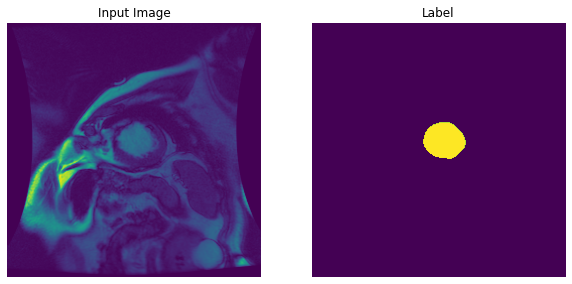

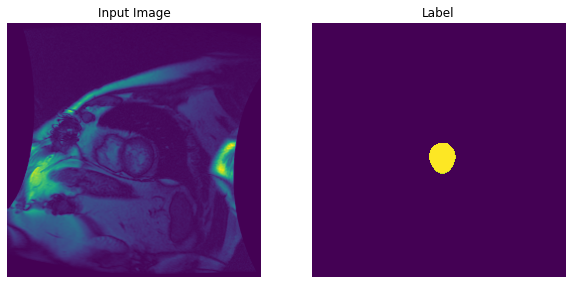

In [12]:
# display an image and label from the training set
for image, label in train.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

In [13]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>

Let us resave the data in an npz format, which is another file format for saving the data for training

In [14]:
import numpy as np
def _raise(e):
    raise e
def save_full_training_data(directory, filename, data, label, axes):
    """Save training data in ``.npz`` format."""
    len(axes) == data.ndim or _raise(ValueError())
    np.savez(directory + filename, data = data, label = label, axes = axes)

We should also normalize the input data for better training performance

In [15]:
def normalizeFloatZeroOne(x, pmin=3, pmax=99.8, axis=None, eps=1e-20, dtype=np.float32):

    mi = np.percentile(x, pmin, axis=axis, keepdims=True)
    ma = np.percentile(x, pmax, axis=axis, keepdims=True)
    return normalizer(x, mi, ma, eps=eps, dtype=dtype)
def normalizer(x, mi, ma, eps=1e-20, dtype=np.float32):


    if dtype is not None:
        x = x.astype(dtype, copy=False)
        mi = dtype(mi) if np.isscalar(mi) else mi.astype(dtype, copy=False)
        ma = dtype(ma) if np.isscalar(ma) else ma.astype(dtype, copy=False)
        eps = dtype(eps)

    x = (x - mi) / (ma - mi + eps)

    x = normalizeZeroOne(x)
    return x


def normalizeZeroOne(x):
    x = x.astype('float32')

    minVal = np.min(x)
    maxVal = np.max(x)

    x = ((x - minVal) / (maxVal - minVal + 1.0e-20))

    return x    

The disadvantage of the npz file is that all of the data has to be loaded into memory and in this case while this was possible to do this with a tensorflow data object, it quickly runs out of memory on a Laptop, hence in the cell below we only save, upload and re-open the saved test data in npz format

In [18]:

dataarr = []
labelarr = []

for image, label in test_dataset:
    dataarr.append(tf.reshape(image,[256, 256, 1]))
    labelarr.append(tf.reshape(label,[256, 256, 1]))    

dataarr = np.asarray(dataarr)
labelarr = np.asarray(labelarr)

In [19]:
from sklearn.model_selection import train_test_split
save_name = 'heart_ventrical'
save_name_val = 'heart_ventricalval'
train_size = 0.95
axes = 'SYXC'
print(dataarr.shape)
traindata, validdata, trainlabel, validlabel = train_test_split(dataarr, labelarr, train_size = train_size,
test_size = 1 - train_size, shuffle = True)
save_full_training_data(get_data_dir, save_name, traindata, trainlabel, axes)
save_full_training_data(get_data_dir, save_name_val, validdata, validlabel, axes)


(26, 256, 256, 1)


Now we will just upload the npz file again to zenodo and have a much easy to open dataset which is what we will do below

In [ ]:
get_npz_data_dir = current_dir + '/data_zenodo_npz/'

Path(get_npz_data_dir).mkdir(exist_ok=True)



#Get the training data from zenodo saved as tf.records
origin = 'https://zenodo.org/record/6944119/files/heart_ventrical.npz' 
file_hash = '141b5a49af571898618a2add24da1a1e'
get_file(origin = origin, file_hash = file_hash, cache_subdir = get_npz_data_dir)

#Get the validation data from zenodo saved as tf.records
origin = 'https://zenodo.org/record/6944119/files/heart_ventricalval.npz' 
file_hash = 'e703d2b513353751a1efd53118c2c6a9'
get_file(origin = origin, file_hash = file_hash, cache_subdir = get_npz_data_dir)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of e703d2b513353751a1efd53118c2c6a9 so we will re-download the data.
656116/656116 [==============================] - 0s 0us/step


'c:\\Users\\rando\\Downloads\\goodplacepython/data_zenodo_npz/heart_ventricalval.npz'

Load data from npz

In [ ]:
def load_full_training_data(directory, filename, axes=None, verbose=True):
    """ Load training data in .npz format.
    The data file is expected to have the keys 'data' and 'label'     
    """

    if directory is not None:
        npzdata = np.load(directory + filename)
    else:
        npzdata = np.load(filename)

    X = npzdata['data']
    Y = npzdata['label']
    axes = npzdata['axes']
   
    n_train = len(X)
    image_size = X[0].shape
    n_dim = len(image_size)
    print('number of  images:\t', n_train)
    print('image size (%dD):\t\t' % n_dim, image_size)
    print('axes:\t\t\t\t', axes)


    return (X, Y), axes

In [ ]:
(X, Y), axes = load_full_training_data(get_npz_data_dir, save_name + '.npz')

number of  images:	 24
image size (2D):		 (256, 256)
axes:				 YXC


So why do we use npz file and not TFRecordDataset format all the time? Remember that in 4 we had to define a dictionary of the image features description to be able to open the dataset which then we can only load in batches to perform the traiing, that assumes that the size of the images is the same for all of the images in the dataset, this may not always be the case and hence when faced with the situation of making patches from a data that has different sized input images it is better to create an npz file format of patches for training. Hence it is a very use case dependent choice that has to be made and therefore it is good to know different ways if I/O of data using different libraries, Let us demonstrate some datasets that are available via Keras and can be easily downloaded as a zip file containing data and labels for the task of classification/localization.